In [ ]:
# Core scientific stack pinned to avoid ABI breaks & Colab conflicts
%pip -q install "numpy>=1.26.0,<2.1"  "pandas==2.2.2" "scipy>=1.14.0" "pyarrow==17.0.0" "requests==2.32.4" "packaging>=24.2"
# Project libs (do NOT upgrade numpy/pandas here)
%pip -q install yfinance praw python-dotenv scikit-learn==1.6.0 matplotlib plotly

# OpenAI SDK pinned to classic 0.28 API (simple, proven, zero 'proxies'/pydantic drama)
%pip -q install "openai==0.28.1"

# Optional UI
%pip -q install -U streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.2 MB/s eta 0:00:00


In [ ]:
import os, json, re, time, warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,5)

DATA = Path("/content/data"); DATA.mkdir(parents=True, exist_ok=True)
TRADING_DAYS = 252
RF = 0.02  # 2% risk-free
print("⚠️ Educational use only. Not financial advice.")


⚠️ Educational use only. Not financial advice.


In [ ]:
# 🔒 Replace with your real values. Never share publicly.
os.environ["REDDIT_CLIENT_ID"]     = "OEsCGObxrk9a6Hu03AqbvQ"
os.environ["REDDIT_CLIENT_SECRET"] = "YD7E6sRNLJZa8BxPaYIZ7UIeQ4Sw0Q"
os.environ["REDDIT_USER_AGENT"]    = "script:rebalanceai:0.1 (by u/Infinityg1)"

# OpenAI key (for LLM sentiment + agent explanations)
os.environ["OPENAI_API_KEY"]       = "api_key"
# (Optional) Claude and Gemini for multi-LLM evaluation
# os.environ["ANTHROPIC_API_KEY"]  = "sk-ant-..."
# os.environ["GOOGLE_API_KEY"]     = "AIza..."


In [ ]:
import praw

reddit = praw.Reddit(
    client_id=os.environ["REDDIT_CLIENT_ID"],
    client_secret=os.environ["REDDIT_CLIENT_SECRET"],
    user_agent=os.environ["REDDIT_USER_AGENT"],
    check_for_async=False,
)
reddit.read_only = True

# Smoke test
try:
    print("Reddit OK:", next(reddit.subreddit("stocks").hot(limit=1)).title[:80])
except Exception as e:
    raise RuntimeError(f"Reddit auth failed: {e}")

def fetch_reddit_mentions(ticker, subreddits=("stocks","investing","wallstreetbets"), limit=50):
    q = f'title:"{ticker}" OR selftext:"{ticker}" OR title:"${ticker}" OR selftext:"${ticker}"'
    rows=[]
    for sub in subreddits:
        try:
            for p in reddit.subreddit(sub).search(q, sort="new", limit=limit):
                rows.append({
                    "subreddit": sub,
                    "created_utc": pd.to_datetime(p.created_utc, unit="s"),
                    "title": p.title or "",
                    "text": getattr(p, "selftext", "") or "",
                    "score": p.score,
                    "permalink": f"https://reddit.com{p.permalink}",
                })
        except Exception as e:
            rows.append({"subreddit": sub, "created_utc": None, "title": f"ERROR: {e}", "text":"", "score": None, "permalink": None})
    return pd.DataFrame(rows)

def cache_reddit(df: pd.DataFrame, ticker: str):
    fp = DATA / f"reddit_{ticker}.csv"
    df.to_csv(fp, index=False)
    return fp

def reddit_sentiment_baseline(df: pd.DataFrame) -> float:
    """Deterministic toy sentiment from upvotes. Squashed to [-1,1]."""
    if df is None or df.empty: return 0.0
    s = df["score"].fillna(0).clip(-50, 500)
    if s.abs().sum() == 0: return 0.0
    raw = (s.sum() / (len(s)*500)) * 2 - 1
    return float(np.tanh(raw))


Reddit OK: Rate My Portfolio - r/Stocks Quarterly Thread September 2025


In [ ]:
import yfinance as yf

# Keep tight for demo; expand later if you want
TICKERS = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","JPM","V","BRK-B"]

prices = yf.download(TICKERS, period="5y", interval="1d", auto_adjust=True, threads=True)["Close"].dropna(how="all")
prices.to_parquet(DATA / "prices.parquet")
print("prices shape:", prices.shape)

rets = prices.pct_change().dropna()
mean_ret_annual = rets.mean() * TRADING_DAYS
vol_annual = rets.std() * np.sqrt(TRADING_DAYS)
sharpe = (mean_ret_annual - RF) / vol_annual

metrics = pd.DataFrame({
    "mean_ret_annual": mean_ret_annual,
    "vol_annual": vol_annual,
    "sharpe": sharpe
}).sort_values("sharpe", ascending=False)

metrics.head(10)


[*********************100%***********************]  10 of 10 completed

prices shape: (1256, 10)


,mean_ret_annual,vol_annual,sharpe
Ticker,,,
NVDA,0.659990,0.522669,1.224465
JPM,0.277247,0.252744,1.017817
BRK-B,0.187582,0.175853,0.952966
GOOGL,0.289912,0.310139,0.870294
MSFT,0.217594,0.259265,0.762132
META,0.299718,0.435633,0.642097
AAPL,0.201833,0.284214,0.639775
TSLA,0.411001,0.612928,0.637924
V,0.144416,0.230319,0.540189


from matplotlib import pyplot as plt
_df_0['mean_ret_annual'].plot(kind='hist', bins=20, title='mean_ret_annual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['vol_annual'].plot(kind='hist', bins=20, title='vol_annual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['sharpe'].plot(kind='hist', bins=20, title='sharpe')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='mean_ret_annual', y='vol_annual', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='vol_annual', y='sharpe', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['mean_ret_annual'].plot(kind='line', figsize=(8, 4), title='mean_ret_annual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['vol_annual'].plot(kind='line', figsize=(8, 4), title='vol_annual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['sharpe'].plot(kind='line', figsize=(8, 4), title='sharpe')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
sentiment_by_ticker = {}
for t in TICKERS:
    try:
        fp = DATA / f"reddit_{t}.csv"
        if fp.exists():
            df = pd.read_csv(fp)
        else:
            df = fetch_reddit_mentions(t, limit=50)
            cache_reddit(df, t)
        sentiment_by_ticker[t] = reddit_sentiment_baseline(df)
        time.sleep(0.2)  # gentle
    except Exception as e:
        sentiment_by_ticker[t] = 0.0
        print(f"[warn] {t}: {e}")

senti_series = pd.Series(sentiment_by_ticker, name="reddit_sentiment")
senti_series.to_csv(DATA / "reddit_sentiment.csv")
senti_series


,reddit_sentiment
AAPL,-0.549250
MSFT,-0.501339
NVDA,-0.471979
AMZN,-0.482604
GOOGL,-0.403582
META,-0.426840
TSLA,-0.403202
JPM,-0.578133
V,-0.504487
BRK-B,-0.620021


In [ ]:
import openai
openai.api_key = os.environ["OPENAI_API_KEY"]

def llm_sentiment_for_ticker(ticker: str, posts_df: pd.DataFrame, max_items: int = 25):
    docs=[]
    if posts_df is not None and not posts_df.empty:
        top = posts_df.copy()
        if "score" in top.columns:
            top = top.sort_values("score", ascending=False)
        for _, row in top.head(max_items).iterrows():
            t = str(row.get("title",""))[:200]
            x = str(row.get("text",""))[:200]
            docs.append(f"{t} :: {x}")
    blob = "\n".join(f"- {d}" for d in docs)[:4000]

    system = (
        "You are a finance research assistant. Output STRICT JSON with fields "
        '{"sentiment": number between -1 and 1, "rationale": short string}. '
        "If evidence is mixed, keep sentiment near 0. No extra text."
    )
    user = f"Ticker: {ticker}\nTEXT:\n{blob}"

    try:
        resp = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            temperature=0.2,
            messages=[{"role":"system","content":system},{"role":"user","content":user}],
        )
        content = (resp.choices[0].message["content"] or "").strip()
    except Exception as e:
        return 0.0, f"OpenAI error: {e} (neutral fallback)"

    m = re.search(r"\{[\s\S]*\}", content)
    if not m:
        return 0.0, "No parsable JSON; default neutral."
    try:
        j = json.loads(m.group(0))
        s = float(j.get("sentiment", 0.0)); s = max(-1.0, min(1.0, s))
        rationale = str(j.get("rationale", ""))[:300]
        return s, rationale
    except Exception:
        return 0.0, "JSON parse error; default neutral."


In [ ]:
LLM_SENTI = {}
for t in ["NVDA","AAPL","MSFT"]:  # keep small to save tokens; expand if you want
    fp = DATA / f"reddit_{t}.csv"
    if fp.exists():
        df = pd.read_csv(fp)
        s, r = llm_sentiment_for_ticker(t, df, max_items=25)
        LLM_SENTI[t] = {"sentiment": s, "rationale": r}

(Path(DATA / "llm_sentiment.json")).write_text(json.dumps(LLM_SENTI, indent=2))
LLM_SENTI


{'NVDA': {'sentiment': 0.1,
  'rationale': 'Mixed evidence with some positive gains reported but also mentions of stock declines and external competition.'},
 'AAPL': {'sentiment': 0.1,
  'rationale': 'Mixed signals with positive earnings report and revenue growth, but concerns about competition and potential losses in streaming.'},
 'MSFT': {'sentiment': 0.3,
  'rationale': 'Mixed evidence with positive earnings report and significant deal with Nebius, but concerns about competition from GOOGL and bearish sentiment in the market.'}}

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df = metrics.copy()
df["senti"] = senti_series.reindex(df.index).fillna(0.0)
for t, obj in LLM_SENTI.items():
    if t in df.index:
        df.loc[t, "senti"] = float(obj["sentiment"])

sc = MinMaxScaler()
df["ret_n"]   = sc.fit_transform(df[["mean_ret_annual"]])
df["risk_n"]  = sc.fit_transform(-df[["vol_annual"]])  # lower vol is better
df["senti_n"] = sc.fit_transform(df[["senti"]])

# Moderate default; tweak per profile
w_ret, w_risk, w_senti = 0.5, 0.3, 0.2
df["score"] = (w_ret*df["ret_n"] + w_risk*df["risk_n"] + w_senti*df["senti_n"]).clip(lower=0)

def allocate(df, max_w=0.25, min_w=0.0):
    s = df["score"].clip(lower=0)
    w = (s / s.sum()) if s.sum()!=0 else pd.Series(1/len(s), index=s.index)
    w = w.clip(lower=min_w, upper=max_w)
    return (w / w.sum()).sort_values(ascending=False)

weights = allocate(df, max_w=0.25)
weights.head(10)


,score
Ticker,
NVDA,0.176831
MSFT,0.131530
AAPL,0.113034
GOOGL,0.101720
JPM,0.099200
BRK-B,0.089579
META,0.081504
TSLA,0.078098
V,0.076753


{'ann_return': 0.3157, 'ann_vol': 0.2561, 'sharpe': 1.1543}


[*********************100%***********************]  1 of 1 completed


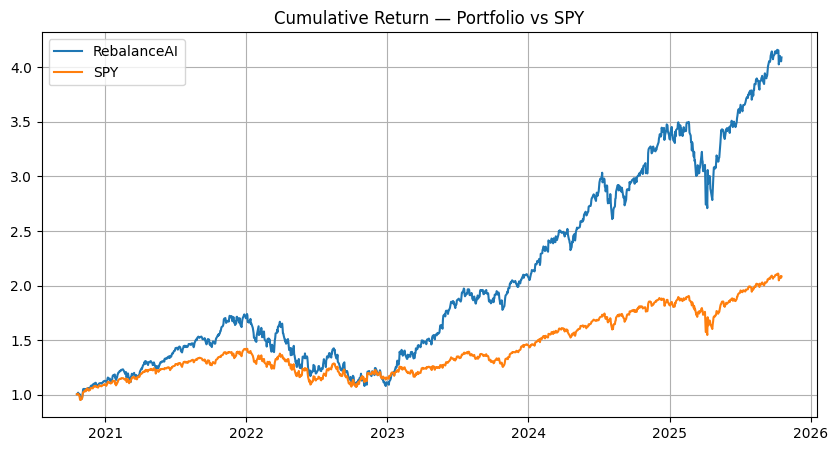

In [ ]:
cov = rets.cov() * TRADING_DAYS
w_vec = weights.reindex(rets.columns).fillna(0).values
ann_vol = float(np.sqrt(w_vec @ cov.values @ w_vec))
ann_ret = float((weights.reindex(rets.columns).fillna(0) * (rets.mean()*TRADING_DAYS)).sum())
ann_sharpe = (ann_ret - RF) / ann_vol if ann_vol>0 else 0.0
print({"ann_return": round(ann_ret,4), "ann_vol": round(ann_vol,4), "sharpe": round(ann_sharpe,4)})

spy = yf.download("SPY", period="5y", auto_adjust=True)["Close"]
port_curve  = (rets @ weights.reindex(rets.columns).fillna(0)).add(1).cumprod()
bench_curve = spy.pct_change().dropna().add(1).cumprod()

plt.plot(port_curve, label="RebalanceAI")
plt.plot(bench_curve.reindex(port_curve.index), label="SPY")
plt.legend(); plt.title("Cumulative Return — Portfolio vs SPY"); plt.grid(True); plt.show()


In [ ]:
from pathlib import Path

app_code = """
import os, re, json, numpy as np, pandas as pd
import yfinance as yf
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import streamlit as st

# ----------------- Constants & App Config -----------------
DATA = Path("/content/data"); DATA.mkdir(parents=True, exist_ok=True)
TRADING_DAYS = 252
RF = 0.02  # simple risk-free assumption
st.set_page_config(page_title="RebalanceAI", layout="wide")
st.title("💹 RebalanceAI — Portfolio Copilot")
st.caption("Educational use only. Not financial advice.")

# ----------------- Universe / Constituents -----------------
TECH_DEFAULT = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META"]
# Curated large-cap fallback set (subset of S&P 500)
UNIVERSE = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","AVGO","PEP","KO","PG","JNJ","XOM",
    "CVX","V","MA","JPM","UNH","HD","COST","PFE","ABBV","TMO","MRK","ADBE","CRM","NFLX","AMD","ORCL","LIN",
    "BAC","WMT","DIS","NKE","CSCO","INTC","TXN","QCOM","HON","CAT","BA","LOW","AMAT","IBM","VRTX","LRCX","NOW",
    "MCD","BKNG","ISRG","DUK","SO","NEE","SBUX","GE","UPS","MS","GS","BLK","SPGI","ELV","CVS","CMCSA","MDT"
]

STOPWORDS = {
    # common english words that sometimes get picked up as "tickers"
    "A","AN","AND","ARE","AS","AT","BE","BUT","BY","FOR","FROM","HAD","HAS","HAVE","HE","HER","HERS","HIM","HIS",
    "HOW","I","IF","IN","INTO","IS","IT","ITS","ME","MY","OF","ON","OR","OUR","OUT","SHE","SO","THAN","THAT",
    "THE","THEIR","THEM","THEN","THERE","THESE","THEY","THIS","TO","UP","US","WAS","WE","WHAT","WHEN","WHERE",
    "WHICH","WHO","WHOM","WHY","WILL","WITH","YOU","YOUR","YOURS","GIVE","HAVE","ME","ON"
}

def load_sp500_constituents():
    \"\"\"
    Optional: read /content/data/sp500.csv with a column 'Symbol'.
    If not found or malformed, return the curated UNIVERSE instead.
    \"\"\"
    try:
        fp = DATA / "sp500.csv"
        if fp.exists():
            df = pd.read_csv(fp)
            syms = [str(s).strip().upper() for s in df["Symbol"].dropna().tolist()]
            syms = [s.replace(".", "-") for s in syms]
            return sorted(set(syms))
    except Exception:
        pass
    return sorted(set(UNIVERSE + TECH_DEFAULT))

VALID_TICKERS = set(load_sp500_constituents())

def parse_tickers(text: str):
    \"\"\"
    Extract explicit uppercase tokens and keep only those in VALID_TICKERS.
    Drop common English stopwords.
    \"\"\"
    raw = re.findall(r"\\b[A-Z]{1,5}\\b", text.upper())
    cleaned = []
    for tok in raw:
        if tok in STOPWORDS:
            continue
        if tok in VALID_TICKERS:
            cleaned.append(tok)
    seen = set()
    out = []
    for t in cleaned:
        if t not in seen:
            out.append(t); seen.add(t)
    return out

# ----------------- Cacheable Data Helpers -----------------
@st.cache_data(show_spinner=False, ttl=600)
def load_prices(tickers, period="5y", interval="1d"):
    \"\"\"Cached yfinance download. Both Analyzer and Chat reuse this cache.\"\"\"
    if not isinstance(tickers, (list, tuple)):
        tickers = [tickers]
    raw = yf.download(list(tickers), period=period, interval=interval, auto_adjust=True, threads=True)
    if "Close" in raw:
        px = raw["Close"]
    else:
        px = raw
    if isinstance(px, pd.Series):  # single ticker → frame
        px = px.to_frame(name=tickers[0])
    return px.dropna(how="all")

def compute_metrics(prices):
    rets = prices.pct_change().dropna()
    m = rets.mean() * TRADING_DAYS
    v = rets.std() * np.sqrt(TRADING_DAYS)
    s = (m - RF) / v
    metrics = pd.DataFrame({"mean_ret_annual": m, "vol_annual": v, "sharpe": s})
    return metrics, rets

# ----------------- Sentiment Helpers -----------------
def reddit_baseline_sentiment(ticker):
    fp = DATA / f"reddit_{ticker}.csv"
    if not fp.exists():
        return 0.0
    try:
        df = pd.read_csv(fp)
        ss = df["score"].fillna(0).clip(-50, 500)
        if ss.abs().sum() == 0:
            return 0.0
        raw = (ss.sum() / (len(ss) * 500)) * 2 - 1
        return float(np.tanh(raw))
    except Exception:
        return 0.0

def load_llm_sentiment():
    fp = DATA / "llm_sentiment.json"
    if fp.exists():
        try:
            return json.loads(fp.read_text())
        except Exception:
            return {}
    return {}

def get_sentiment_map(tickers, use_llm=True):
    out = {t: reddit_baseline_sentiment(t) for t in tickers}
    if use_llm:
        cache = load_llm_sentiment()
        for t, obj in cache.items():
            if t in out and "sentiment" in obj:
                try:
                    out[t] = float(obj["sentiment"])
                except Exception:
                    pass
    return pd.Series(out)

# ----------------- Fusion & Allocation -----------------
def fuse_and_allocate(metrics, senti_series, profile="Moderate", max_w=0.25):
    df = metrics.copy()
    df["senti"] = senti_series.reindex(df.index).fillna(0.0)
    sc = MinMaxScaler()
    df["ret_n"]   = sc.fit_transform(df[["mean_ret_annual"]])
    df["risk_n"]  = sc.fit_transform(-df[["vol_annual"]])  # lower vol is better
    df["senti_n"] = sc.fit_transform(df[["senti"]])

    p = str(profile).lower()
    if p.startswith("cons"):
        w_ret, w_risk, w_senti = 0.3, 0.5, 0.2
    elif p.startswith("agg"):
        w_ret, w_risk, w_senti = 0.6, 0.2, 0.2
    else:
        w_ret, w_risk, w_senti = 0.5, 0.3, 0.2

    df["score"] = (w_ret*df["ret_n"] + w_risk*df["risk_n"] + w_senti*df["senti_n"]).clip(lower=0)

    w = df["score"]
    if w.sum() == 0:
        w = pd.Series(1/len(w), index=w.index)
    else:
        w = w / w.sum()
    w = w.clip(upper=max_w)
    w = w / (w.sum() if w.sum()!=0 else 1)
    return w.sort_values(ascending=False), df, (w_ret, w_risk, w_senti)

# ----------------- Robust Stats (with fallback) -----------------
def portfolio_stats(rets, weights, metrics_fallback=None):
    # Keep only columns present in weights
    cols = [c for c in rets.columns if c in weights.index]
    if not cols:
        if metrics_fallback is not None:
            m = metrics_fallback.loc[weights.index].dropna()
            w_use = weights.reindex(m.index).fillna(0)
            ann_ret = float((w_use * m["mean_ret_annual"]).sum())
            ann_vol = float((w_use * m["vol_annual"]).sum())  # crude fallback
            sharpe  = (ann_ret - RF) / ann_vol if ann_vol > 1e-12 else 0.0
            return {"ann_return": round(ann_ret,4), "ann_vol": round(ann_vol,4), "sharpe": round(sharpe,4)}
        return {"ann_return": 0.0, "ann_vol": 0.0, "sharpe": 0.0}

    rets_use = rets[cols].dropna(how="any")
    if rets_use.empty:
        if metrics_fallback is not None:
            m = metrics_fallback.loc[weights.index].dropna()
            w_use = weights.reindex(m.index).fillna(0)
            ann_ret = float((w_use * m["mean_ret_annual"]).sum())
            ann_vol = float((w_use * m["vol_annual"]).sum())
            sharpe  = (ann_ret - RF) / ann_vol if ann_vol > 1e-12 else 0.0
            return {"ann_return": round(ann_ret,4), "ann_vol": round(ann_vol,4), "sharpe": round(sharpe,4)}
        return {"ann_return": 0.0, "ann_vol": 0.0, "sharpe": 0.0}

    w_use = weights.reindex(rets_use.columns).fillna(0)
    cov = rets_use.cov().fillna(0) * TRADING_DAYS
    wv = w_use.values
    ann_vol = float(np.sqrt(max(wv @ cov.values @ wv, 0)))
    ann_ret = float((w_use * (rets_use.mean()*TRADING_DAYS)).sum())
    sharpe  = (ann_ret - RF) / ann_vol if ann_vol > 1e-12 else 0.0
    return {"ann_return": round(ann_ret,4), "ann_vol": round(ann_vol,4), "sharpe": round(sharpe,4)}

def cumulative_curves(rets, weights):
    cols = [c for c in rets.columns if c in weights.index]
    rets_use = rets[cols].dropna(how="any")
    w_use = weights.reindex(cols).fillna(0)
    port = (rets_use @ w_use).add(1).cumprod()
    if isinstance(port, pd.DataFrame): port = port.squeeze()
    port = pd.Series(port, name="RebalanceAI")

    spy = yf.download("SPY", period="5y", auto_adjust=True)
    spy_close = spy["Close"] if "Close" in spy else spy.squeeze()
    if isinstance(spy_close, pd.DataFrame): spy_close = spy_close.squeeze()
    bench = spy_close.pct_change().dropna().add(1).cumprod()
    if isinstance(bench, pd.DataFrame): bench = bench.squeeze()
    bench = pd.Series(bench, name="SPY").reindex(port.index).ffill()
    return pd.concat([port, bench], axis=1)

# ----------------- Chat Parsers -----------------
def parse_amount(text):
    t = text.lower().replace(",", "").strip()
    # Prefer $ amounts
    m = re.search(r"\\$\\s*([0-9]+(?:\\.[0-9]+)?)", t)
    if m:
        try: return float(m.group(1))
        except: pass
    # 100k/1.5m style
    m = re.search(r"\\b([0-9]+(?:\\.[0-9]+)?)([kKmM])\\b", t)
    if m:
        val = float(m.group(1)); suf = m.group(2).lower()
        return val * (1_000 if suf=="k" else 1_000_000)
    # fallback: largest standalone number >= 1000 as budget
    nums = [float(x) for x in re.findall(r"\\b[0-9]+(?:\\.[0-9]+)?\\b", t)]
    big = [x for x in nums if x >= 1000]
    if big: return max(big)
    return None

def parse_stock_count(text):
    m = re.search(r"\\b(\\d+)\\s+stocks?\\b", text.lower())
    if m:
        try: return int(m.group(1))
        except: pass
    return None

def parse_target_return(text):
    m = re.search(r"(\\d+(?:\\.\\d+)?)\\s*%+", text)
    if m:
        try: return float(m.group(1)) / 100.0
        except: pass
    return None

def parse_risk(text):
    t = text.lower()
    if "conserv" in t: return "Conservative"
    if "moderate" in t: return "Moderate"
    if "aggress" in t or "high risk" in t: return "Aggressive"
    return "Moderate"

# ----------------- UI -----------------
tab_analyze, tab_chat = st.tabs(["Analyzer", "Chat"])

with tab_analyze:
    raw = st.text_input("Tickers (comma-separated)", "AAPL,NVDA,MSFT,AMZN,GOOGL")
    tickers = [t.strip().upper() for t in raw.split(",") if t.strip()]
    # filter to valid universe to avoid typos
    tickers = [t for t in tickers if t in VALID_TICKERS]
    if not tickers:
        st.info("No valid tickers detected; using a default tech set.")
        tickers = TECH_DEFAULT

    profile = st.selectbox("Risk Profile", ["Conservative","Moderate","Aggressive"], index=1)
    use_llm = st.checkbox("Use LLM sentiment (if cached)", True)
    max_w = st.slider("Max single weight", 0.05, 0.5, 0.25, 0.05)
    amount = st.number_input("Investment amount ($)", min_value=100, value=10000, step=100)

    if st.button("Analyze", type="primary"):
        prices = load_prices(tickers)                 # ✅ cached yfinance download
        metrics, rets = compute_metrics(prices)
        senti = get_sentiment_map(tickers, use_llm=use_llm)
        weights, fused_df, (wr, wk, ws) = fuse_and_allocate(metrics, senti, profile=profile, max_w=max_w)

        st.subheader("Suggested Weights"); st.bar_chart(weights)

        last_prices = prices.iloc[-1].reindex(weights.index)
        alloc_dollars = (weights * amount).round(2)
        est_shares = (alloc_dollars / last_prices).replace([np.inf,-np.inf], np.nan).fillna(0).apply(np.floor).astype(int)
        st.subheader("Allocation Plan")
        st.dataframe(pd.DataFrame({
            "weight": weights.round(4),
            "dollars": alloc_dollars,
            "last_price": last_prices.round(2),
            "est_shares": est_shares
        }))
        st.caption(f"Fusion weights: return={wr}, risk={wk}, sentiment={ws}; cap={max_w}")

        st.subheader("Portfolio Stats")
        st.write(portfolio_stats(rets, weights, metrics_fallback=metrics.loc[weights.index]))

        st.subheader("Cumulative Return vs SPY")
        st.line_chart(cumulative_curves(rets, weights))

with tab_chat:
    st.markdown("**Ask RebalanceAI** (examples):")
    st.code(
        'I want to invest $100,000 with ≥20% target, which 5 stocks?\\n'
        'Analyze a $10,000 portfolio for moderate risk and tech emphasis.\\n'
        'Compare TSLA vs. NVDA on volatility, Sharpe, and recent news sentiment.\\n'
        'Propose a diversified S&P 500 mini-basket for a conservative profile.'
    )
    use_llm_chat = st.checkbox("Use LLM sentiment in chat (if cached)", True, key="use_llm_chat")
    max_w_chat = st.slider("Max single weight (chat)", 0.05, 0.5, 0.25, 0.05, key="mw_chat")

    if "chat_history" not in st.session_state:
        st.session_state.chat_history = []

    for role, content in st.session_state.chat_history:
        with st.chat_message(role):
            st.markdown(content)

    user_msg = st.chat_input("Type your question...")
    if user_msg:
        st.session_state.chat_history.append(("user", user_msg))
        with st.chat_message("user"):
            st.markdown(user_msg)

        try:
            txt = user_msg.strip()
            amount = parse_amount(txt) or 10000.0
            risk = parse_risk(txt)
            tix = parse_tickers(txt)                   # ✅ strict & universe-filtered
            n = parse_stock_count(txt) or 5
            target_ret = parse_target_return(txt)      # e.g., 0.20 for 20%

            # ----- INTENT: compare -----
            if "compare" in txt.lower() and len(tix) >= 2:
                comp = tix[:2]
                prices = load_prices(comp)                      # ✅ cached
                metrics, rets = compute_metrics(prices)
                senti = get_sentiment_map(comp, use_llm=use_llm_chat)
                table = pd.concat([metrics.round(4), senti.rename("sentiment")], axis=1)

                with st.chat_message("assistant"):
                    st.markdown(f"**Comparison — {comp[0]} vs {comp[1]}**")
                    st.dataframe(table)
                    st.caption("Higher Sharpe = better risk-adjusted returns; lower vol = more stable; sentiment in [-1,1].")

            # ----- INTENT: diversified basket -----
            elif "mini-basket" in txt.lower() or ("diversified" in txt.lower() and "s&p" in txt.lower()):
                basket = ["MSFT","JNJ","PG","KO","PEP","V","JPM","UNH","XOM","HD"]
                prices = load_prices(basket)                    # ✅ cached
                metrics, rets = compute_metrics(prices)
                senti = get_sentiment_map(basket, use_llm=use_llm_chat)
                weights_all, fused_df, (wr, wk, ws) = fuse_and_allocate(metrics, senti, profile="Conservative", max_w=max_w_chat)

                weights = weights_all.head(n)
                weights = weights / weights.sum()

                sub_prices = prices[weights.index]
                metrics_sub, sub_rets = compute_metrics(sub_prices)
                last_prices = sub_prices.iloc[-1]
                alloc_dollars = (weights * amount).round(2)
                est_shares = (alloc_dollars / last_prices).replace([np.inf,-np.inf], np.nan).fillna(0).apply(np.floor).astype(int)

                with st.chat_message("assistant"):
                    st.markdown(f"**Diversified S&P Mini-Basket (Conservative)** — amount=${amount:,.0f}, top {n}")
                    st.write({"fusion_weights": {"return": wr, "risk": wk, "sentiment": ws}, "cap": max_w_chat})
                    st.dataframe(pd.DataFrame({
                        "weight": weights.round(4),
                        "dollars": alloc_dollars,
                        "last_price": last_prices.round(2),
                        "est_shares": est_shares
                    }))

                    if target_ret is not None:
                        approx_ann_ret = float((weights * metrics_sub.loc[weights.index, "mean_ret_annual"]).sum())
                        if approx_ann_ret < target_ret:
                            st.info(
                                f"Note: Estimated annual return ≈ {approx_ann_ret:.0%}, below your target of {target_ret:.0%}. "
                                "Hitting ≥ target often requires higher concentration and volatility."
                            )

                    st.markdown("**Portfolio Stats**")
                    st.write(portfolio_stats(sub_rets, weights, metrics_fallback=metrics_sub.loc[weights.index]))
                    st.line_chart(cumulative_curves(sub_rets, weights))

            # ----- INTENT: general portfolio suggestion -----
            else:
                tech_emphasis = ("tech" in txt.lower()) or ("technology" in txt.lower())
                if not tix:
                    tix = TECH_DEFAULT if tech_emphasis else list(VALID_TICKERS)

                prices = load_prices(tix)                        # ✅ cached
                metrics, rets = compute_metrics(prices)
                senti = get_sentiment_map(tix, use_llm=use_llm_chat)

                # Bias pool to names with mean >= target if requested; else use full pool
                if target_ret is not None:
                    hi = metrics[metrics["mean_ret_annual"] >= target_ret].index.tolist()
                    base_pool = hi if len(hi) >= n else metrics.index.tolist()
                else:
                    base_pool = metrics.index.tolist()

                weights_all, fused_df, (wr, wk, ws) = fuse_and_allocate(
                    metrics.loc[base_pool], senti.reindex(base_pool).fillna(0), profile=risk, max_w=max_w_chat
                )

                top = weights_all.head(n)
                weights = top / top.sum()

                sub_prices = prices[weights.index]
                metrics_sub, sub_rets = compute_metrics(sub_prices)
                last_prices = sub_prices.iloc[-1]
                alloc_dollars = (weights * amount).round(2)
                est_shares = (alloc_dollars / last_prices).replace([np.inf,-np.inf], np.nan).fillna(0).apply(np.floor).astype(int)

                with st.chat_message("assistant"):
                    st.markdown(
                        f"**Portfolio Suggestion** — amount=${amount:,.0f}, risk={risk}, stocks={n}"
                        + (f", target ≥ {int(target_ret*100)}% ann. return" if target_ret is not None else "")
                    )
                    st.write({"fusion_weights": {"return": wr, "risk": wk, "sentiment": ws}, "cap": max_w_chat})
                    st.dataframe(pd.DataFrame({
                        "weight": weights.round(4),
                        "dollars": alloc_dollars,
                        "last_price": last_prices.round(2),
                        "est_shares": est_shares
                    }))

                    st.markdown("**Sentiment snapshot**")
                    st.dataframe(pd.DataFrame({"sentiment": senti.reindex(weights.index).round(3)}).sort_values("sentiment", ascending=False))

                    if target_ret is not None:
                        approx_ann_ret = float((weights * metrics_sub.loc[weights.index, "mean_ret_annual"]).sum())
                        if approx_ann_ret < target_ret:
                            st.info(
                                f"Note: Estimated annual return ≈ {approx_ann_ret:.0%}, below your target of {target_ret:.0%}. "
                                "Consider an Aggressive profile and/or higher cap to increase expected return (with higher risk)."
                            )

                    st.markdown("**Portfolio Stats**")
                    st.write(portfolio_stats(sub_rets, weights, metrics_fallback=metrics_sub.loc[weights.index]))
                    st.line_chart(cumulative_curves(sub_rets, weights))

            with st.chat_message("assistant"):
                st.caption(
                    f"Parsed → amount=${amount:,.0f}, risk={risk}, stocks={n}, "
                    f"target_return={'{:.0%}'.format(target_ret) if target_ret is not None else '—'}"
                )

            st.session_state.chat_history.append(("assistant", "Response shown above."))

        except Exception as e:
            err = f"Sorry, I hit an error: `{e}`"
            st.session_state.chat_history.append(("assistant", err))
            with st.chat_message("assistant"):
                st.markdown(err)
"""

Path("/content/app.py").write_text(app_code)
print("✅ Wrote /content/app.py")


✅ Wrote /content/app.py


In [ ]:
import os, subprocess, time
from pyngrok import ngrok

# === Set your token ===
# Option A (recommended): set env var in a prior cell, or:
# os.environ["NGROK_AUTHTOKEN"] = "YOUR_NEW_NGROK_TOKEN"
# Option B: paste directly here:
TOKEN = os.environ.get("NGROK_AUTHTOKEN") or "34FnRXQGpLzmHYoslYXDYVO5gEW_4U1c7uuv2vZmafSrx6Y1P"
if not TOKEN or TOKEN.startswith("PASTE_"):
    raise RuntimeError("NGROK_AUTHTOKEN missing. Set it in env or paste it into TOKEN above.")

# 1) Kill old tunnels & set token
ngrok.kill()
ngrok.set_auth_token(TOKEN)

# 2) Kill any old Streamlit processes
try:
    subprocess.run(["pkill", "-f", "streamlit"], check=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
except Exception:
    pass

# 3) Start Streamlit in background and capture logs
log_path = "/content/streamlit.log"
with open(log_path, "w") as f:
    pass

proc = subprocess.Popen(
    ["streamlit", "run", "/content/app.py", "--server.port", "8501", "--server.headless", "true"],
    stdout=open(log_path, "a"),
    stderr=subprocess.STDOUT,
    text=True,
)

time.sleep(3)  # give Streamlit a moment to boot

# 4) Open ngrok tunnel
tunnel = ngrok.connect(8501, bind_tls=True)
print("✅ Streamlit public URL:", tunnel.public_url)

# 5) Show last log lines so you can confirm it started
time.sleep(2)
print("\n--- Streamlit log (tail) ---")
try:
    print("\n".join(open(log_path).read().splitlines()[-25:]))
except Exception as e:
    print("Could not read logs:", e)



✅ Streamlit public URL: https://stethoscoped-nondiocesan-cohen.ngrok-free.dev

--- Streamlit log (tail) ---



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://136.113.221.229:8501



In [ ]:
# Minimal agent-like runner without installing LangChain (simple, robust).
# It "orchestrates" the same steps you built, but responds to a prompt.
def rebalance_agent(prompt: str, tickers_csv="AAPL,NVDA,MSFT,AMZN,GOOGL", max_w=0.25):
    tickers = [t.strip() for t in tickers_csv.split(",") if t.strip()]
    # metrics
    sub = prices[tickers].dropna(how="all", axis=0)
    sub_rets = sub.pct_change().dropna()
    m = sub_rets.mean() * TRADING_DAYS
    v = sub_rets.std() * np.sqrt(TRADING_DAYS)
    s = (m - RF) / v
    metrics_local = pd.DataFrame({"mean_ret_annual":m,"vol_annual":v,"sharpe":s})

    # sentiment
    senti = {}
    for t in tickers:
        fp = DATA / f"reddit_{t}.csv"
        base = reddit_sentiment_baseline(pd.read_csv(fp)) if fp.exists() else 0.0
        senti[t] = float(LLM_SENTI.get(t, {}).get("sentiment", base))

    # fuse & allocate
    df_local = metrics_local.copy()
    df_local["senti"] = pd.Series(senti)
    def minmax(x): r=x.max()-x.min(); return (x-x.min())/(r if r else 1)
    df_local["ret_n"]=minmax(df_local["mean_ret_annual"])
    df_local["risk_n"]=minmax(-df_local["vol_annual"])
    df_local["senti_n"]=minmax(df_local["senti"])
    w_ret,w_risk,w_senti=0.5,0.3,0.2
    df_local["score"]=(w_ret*df_local["ret_n"]+w_risk*df_local["risk_n"]+w_senti*df_local["senti_n"]).clip(lower=0)
    w = df_local["score"]/ (df_local["score"].sum() if df_local["score"].sum()!=0 else 1)
    w = w.clip(upper=max_w); w = w/(w.sum() if w.sum()!=0 else 1)

    # stats
    cov = rets.cov() * TRADING_DAYS
    wv  = w.reindex(rets.columns).fillna(0).values
    ann_vol = float(np.sqrt(wv @ cov.values @ wv))
    ann_ret = float((w.reindex(rets.columns).fillna(0) * (rets.mean()*TRADING_DAYS)).sum())
    sharpe  = (ann_ret - RF) / ann_vol if ann_vol>0 else 0.0

    explanation = {
        "prompt": prompt,
        "weights": w.sort_values(ascending=False).round(4).to_dict(),
        "stats": {"ann_return": round(ann_ret,4), "ann_vol": round(ann_vol,4), "sharpe": round(sharpe,4)},
        "notes": "Weights blend return ↑, volatility ↓, Reddit/LLM sentiment ↑ with caps for diversification."
    }
    return explanation

rebalance_agent("Analyze $10k for moderate risk, tech tilt", "AAPL,NVDA,MSFT,AMZN,GOOGL", max_w=0.25)


{'prompt': 'Analyze $10k for moderate risk, tech tilt',
 'weights': {'NVDA': 0.2569,
  'MSFT': 0.2569,
  'AAPL': 0.2171,
  'GOOGL': 0.1835,
  'AMZN': 0.0857},
 'stats': {'ann_return': 0.3326, 'ann_vol': 0.2907, 'sharpe': 1.0753},
 'notes': 'Weights blend return ↑, volatility ↓, Reddit/LLM sentiment ↑ with caps for diversification.'}